## Network Transfer Function: Usage example

![](./classes.png)

### Import modules with respective paths

In [1]:
# this path append is for binder only
import sys
sys.path.append("../../")

#spectrome modules
from spectrome.forward import runforward
from spectrome.utils import functions, path
from spectrome.brain import Brain

#generic modules
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter, firls, decimate

### Create new `Brain()` and populate it

Let us first set up a `Brain()` and its attributes: `connectome`, `ordering`, and `ntf_params`

In [2]:
new_brain = Brain.Brain()

hcp_dir = path.get_data_path() # connectome information is in /data/ dir
new_brain.add_connectome(hcp_dir) # Use default files in /data/

Let's see what the attributes of brain are:

In [3]:
vars(new_brain).keys()

dict_keys(['connectome', 'reducedConnectome', 'distance_matrix', 'permutation', 'ordering', 'laplacian', 'eigenvalues', 'norm_eigenmodes', 'regular_eigenvalues', 'regular_laplacian', 'norm_regular_eigenmodes', 'raw_regular_eigenvectors', 'ntf_params'])

And which have been initialized, so far

In [4]:
vars(new_brain)

{'connectome': array([[0.0000e+00, 5.4250e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.4250e+00, 0.0000e+00, 4.2118e+02, ..., 1.2500e-02, 3.0000e-01,
         6.6250e-01],
        [0.0000e+00, 4.2118e+02, 0.0000e+00, ..., 0.0000e+00, 6.2500e-02,
         9.3750e-01],
        ...,
        [0.0000e+00, 1.2500e-02, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         1.1570e+02],
        [0.0000e+00, 3.0000e-01, 6.2500e-02, ..., 0.0000e+00, 0.0000e+00,
         7.9550e+01],
        [0.0000e+00, 6.6250e-01, 9.3750e-01, ..., 1.1570e+02, 7.9550e+01,
         0.0000e+00]]),
 'reducedConnectome': None,
 'distance_matrix': array([[ 0.    , 38.597 ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [38.597 ,  0.    , 11.69  , ...,  2.0156, 14.584 , 37.644 ],
        [ 0.    , 11.69  ,  0.    , ...,  0.    ,  2.0352, 20.158 ],
        ...,
        [ 0.    ,  2.0156,  0.    , ...,  0.    ,  0.    , 13.273 ],
        [ 0.    , 14.584 ,  2.0352, ...,  0.    ,  0.    , 

We have the connectome (`Cdk_conn`), the distance matrix (`Ddk_conn`), the permanent hcp ordering (`permHCP`), and some defaul parameters for the `network_transfer_function` (`ntf_params`).

Now, the `network_transfer_function` has 4 input parameters:
- `C`: the **reduced** connectivity matrix
- `D`: the distance matrix
- `parameters`: the 7 ntf parameters
- `w`: the frequency at which the ntf will be calculated at.
    
We have all but the first parameter since we need to convert the connectivity matrix to a **reduced** form. This is done by applying 2 functions to the `new_brain`:
- `new_brain.bi_symmetric_c()`
- `new_brain.reduce_extreme_dir()`

In [5]:
# Some re-ordering and normalizing (reduced):
new_brain.reorder_connectome(new_brain.connectome, new_brain.distance_matrix)
new_brain.bi_symmetric_c()
new_brain.reduce_extreme_dir()

print(new_brain.reducedConnectome.shape)

(86, 86)


For the Desikan-Killiany atlas, we have 86 brain regions.|

### Calculating network transfer function for a *range* of frequencies

Now loop over a range of frequencies of interest and calculate the network transfer function.

1. First setup such frequencies:

In [6]:
fs = 600 #sampling frequency
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin,fmax,40)
hbp = firls(101, np.array([0, 0.2*fmin, 0.9*fmin, fmax-2, fmax+5, 100])*2/fs,
           desired = np.array([0, 0, 1, 1, 0, 0])) #for detrending, a bandpass
lpf = np.array([1, 2, 5, 2, 1])
lpf = lpf/np.sum(lpf)
ind_del = hbp.size #number of coefficients in hbp. Delete that number in beginning of signal due to filtering

2. Then calculate the frequency response:

In [7]:
# Compute for all frequencies in fvec:

model_spectrum, freq_response, eigvalues, eigvectors = runforward.run_forward(new_brain, new_brain.ntf_params, fvec)
print(model_spectrum.shape)

(86, 40)


The output for this example is 86 brain regions and 40 frequency bins.

### Plotting the simulated frequency spectra:

Text(0, 0.5, 'Magnitude (dB)')

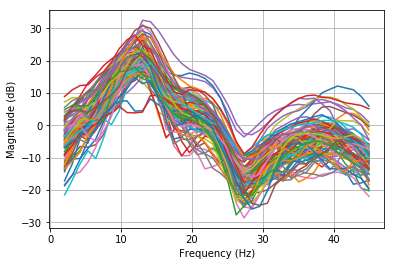

In [10]:
fig = plt.figure(num=5, figsize = (6,4))
for g in range(len(model_spectrum)):
    spectrum = np.abs(model_spectrum[g,:])
    filtered = np.convolve(spectrum, lpf, 'same')
    plt.plot(fvec,functions.mag2db(filtered))

plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
#mpl.plot(fvec,mag2db(np.abs(freq_model)))